Представьте, что вы аналитик в компании, которая разрабатывает приложение для обработки и оформления фотографий в формате Stories (например, для дальнейшего экспорта в Instagram Stories). Был проведен A/B тест: тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика. Ваша основная задача: проанализировать итоги эксперимента и решить, нужно ли выкатывать новую модель на остальных пользователей.

В ходе отчета обоснуйте выбор метрик, на которые вы обращаете внимание. Если различия есть, то объясните, с чем они могут быть связаны и являются ли значимыми.

In [1]:
import pandas as pd
import numpy as np
import requests
from urllib.parse import urlencode
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.stats import norm, mannwhitneyu
from scipy.stats import chi2_contingency, chi2 


%matplotlib inline

1. СЧИТЫВАЕМ ДАННЫЕ

In [2]:
path_active_users = 'https://disk.yandex.ru/d/B4QnY5D5EtKa-A'
path_groups = 'https://disk.yandex.ru/d/jP_BAw_oxS3law'
path_purchases = 'https://disk.yandex.ru/d/AmucCdboEaowhA'

In [3]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = path_active_users  # Вписываете ссылку

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
active_users = pd.read_csv(download_url)
active_users.head()

,user_id,country,platform,sex
0,8029,Russia,ios,male
1,1735,Sweden,ios,male
2,7697,Russia,android,male
3,1421,Sweden,android,female
4,1704,Russia,ios,male


In [4]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = path_groups  # Вписываете ссылку

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
groups = pd.read_csv(download_url)
groups.head()

,user_id,group
0,9149,B
1,9150,B
2,9151,A
3,9152,B
4,9153,B


In [5]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = path_purchases  # Вписываете ссылку

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
purchases = pd.read_csv(download_url)
purchases.head()

,user_id,revenue
0,4412,1000.0
1,9000,701.0
2,9001,700.0
3,9002,702.0
4,5790,1002.0


2. ПОСМОТРИМ НА ДАННЫЕ

In [6]:
# active_users

In [7]:
active_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   8341 non-null   int64 
 1   country   8341 non-null   object
 2   platform  8341 non-null   object
 3   sex       8341 non-null   object
dtypes: int64(1), object(3)
memory usage: 260.8+ KB


In [8]:
active_users.user_id.nunique()

8341

In [9]:
active_users.country.nunique()

2

In [10]:
active_users.country.unique() # данные всего по двум странам

array(['Russia', 'Sweden'], dtype=object)

In [11]:
active_users.platform.nunique()

2

In [12]:
active_users.platform.unique() # данные всего по двум платформам

array(['ios', 'android'], dtype=object)

In [13]:
active_users.sex.nunique() #чтоб уж наверняка знать 

2

In [14]:
# groups

In [15]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  74576 non-null  int64 
 1   group    74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [16]:
groups.user_id.nunique()

74576

In [17]:
groups.group.nunique()

2

In [18]:
groups.group.unique() # контрольная (А) и тестовая(В) группы.Тестовой группе предлагалась новая модель оплаты коллекций шаблонов, контрольной – старая механика

array(['B', 'A'], dtype=object)

In [19]:
# purchases

In [20]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  541 non-null    int64  
 1   revenue  541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [21]:
purchases.user_id.nunique()

541

In [22]:
# Резюме: у нас есть три таблицы с данными по пользователям из двух стран - Швеция и Россия, мужчины и женщины, 
# использующие одну из двух платформ, которые были поделены на тестовую и контрольную группу, 
# а также есть данные об оплатах во время эксперимента.
# Пропусков в данных нет. 

3. A/B ТЕСТИРОВАНИЕ

In [23]:
#посмотрим, как соотносится количество пользивателей в тестовой и контрольной группе
groups.groupby('group', as_index = False)\
    .agg({'user_id' : 'count'})

# тестовую группу (B) c новой моделью оплаты попало большее количество пользователей

,group,user_id
0,A,14693
1,B,59883


In [123]:
groups.group.value_counts(normalize=True).mul(100) # 80 % отдано на тест

B    80.297951
A    19.702049
Name: group, dtype: float64

In [24]:
# посмотрим на это соотношение на пользователях,которые посещали приложение во время эксперимента.
active_users_per_groups = active_users.merge(groups, how = 'inner', on = 'user_id')
active_users_per_groups.head()

,user_id,country,platform,sex,group
0,8029,Russia,ios,male,B
1,1735,Sweden,ios,male,B
2,7697,Russia,android,male,B
3,1421,Sweden,android,female,B
4,1704,Russia,ios,male,B


In [127]:
active_users_per_groups.groupby('group', as_index=False)\
    .agg({'user_id' : 'count'})

,group,user_id
0,A,1538
1,B,6803


In [128]:
active_users_per_groups.group.value_counts(normalize=True).mul(100) # чуть больше 80 % отдано на тест, соотношние сохраняется

B    81.560964
A    18.439036
Name: group, dtype: float64

In [26]:
# посмотрим на активных пользователей, которые произвели оплату
full_df = active_users_per_groups.merge(purchases, how = 'inner', on = 'user_id')
full_df

,user_id,country,platform,sex,group,revenue
0,1202,Sweden,android,male,A,302.0
1,6284,Russia,android,female,B,208.0
2,6554,Sweden,android,female,B,602.0
3,6000,Sweden,ios,male,B,1910.0
4,4046,Sweden,ios,female,B,1909.0
...,...,...,...,...,...,...
387,5435,Russia,android,female,B,1910.0
388,7304,Sweden,android,female,B,1909.0
389,7950,Russia,ios,male,A,3669.0
390,7141,Russia,ios,male,A,298.0


In [129]:
full_df.group.value_counts(normalize=True).mul(100) # чуть больше 80 % отдано на тест, соотношние сохраняется

B    80.102041
A    19.897959
Name: group, dtype: float64

In [27]:
# Если посмотреть выше, по таблице покупок  есть данные о 541 транзакции, но получаестся по этим пользователям 
#  нет данных о поле, стране и используемой платформе. Это 149 пользователей
purchases.shape[0] - full_df.shape[0]

149

In [28]:
# выведем их пока в отдельную таблицу с определением группы 
NaN_df = purchases.merge(groups, how = 'inner', on = 'user_id')\
    .merge(active_users, how = 'left', on = 'user_id')\
    .query('country != ["Russia", "Sweden"]')
NaN_df

,user_id,revenue,group,country,platform,sex
1,9000,701.0,B,NaN,NaN,NaN
2,9001,700.0,B,NaN,NaN,NaN
3,9002,702.0,B,NaN,NaN,NaN
5,9003,641.0,B,NaN,NaN,NaN
6,9004,590.0,B,NaN,NaN,NaN
...,...,...,...,...,...,...
508,9144,209.0,B,NaN,NaN,NaN
512,9145,301.0,B,NaN,NaN,NaN
521,9146,207.0,B,NaN,NaN,NaN
530,9147,408.0,B,NaN,NaN,NaN


In [29]:
# вообще, здесь скорее всего ошибка какая-то - получается, что пользователь сделал транзакцию, не будучи активным.
# возможно, как-то данные не так залогировались. Поэтому, пока эти данные исключаю из дальнейшего анализа.
# Продолжаю только с full_df

На какие метрики стоить обратить внимание в тестовой и контрольной группе? На мой взгляд это конверсия в покупку (CR), средний чек. Конверсия в покупку покажет насколько вообще эффективен новый механизм оплаты, удобно ли им пользоваться, а средний чек покажет в денежном выражении, на сколько мы выигрываем при введении новой системы.
Для начала посмотрим на средние чеки  тестовой и контрольной группе. Проверять будем методом будстрапа. При чем я хочу сделать две проверки: на данных по оплатам только для активных пользователей, и второй - с учетом тех 149 пользователей, которых не нашлось в таблице с активными пользователями, но по ним есть данные о делении на группы.

In [30]:
#посмотрим на средние чеки у активных пользователей

full_df_392 = full_df.groupby('group', as_index=False)\
    .agg({'revenue' : 'sum', 'user_id' : 'count'})
full_df_392  

,group,revenue,user_id
0,A,73598.0,78
1,B,398113.0,314


In [31]:
full_df_392.assign(avg_check = full_df_392.revenue/full_df_392.user_id)


,group,revenue,user_id,avg_check
0,A,73598.0,78,943.564103
1,B,398113.0,314,1267.875796


In [32]:
# Мы видим, что средний чек в тестовой группе вырос. Посмотрим, значимо ли это различие. Применим бутсрап. 
# Нулевая гипотеза говорит нам, что различий в тестовой и контрольной группах нет.
# Альтернативная - что различия есть.

In [33]:
control = full_df.query('group == "A"').revenue

In [34]:
test = full_df.query('group == "B"').revenue

In [35]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

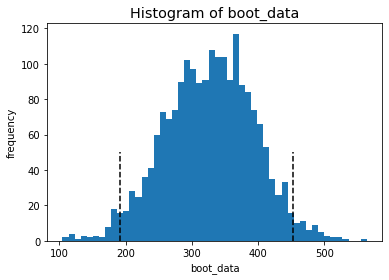

In [36]:
booted_data_mean = get_bootstrap(test, control, boot_it = 2000)

In [37]:
booted_data_mean["p_value"]

1.2062489132494451e-06

In [38]:
booted_data_mean["ci"]

,0
0.025,191.224761
0.975,452.348328


In [39]:
# При сравнении средних в двух группах p-value < 0.05, и 0 в доверительный интервал не попадает. 
# Соответственно, нулевая гипотеза на заданном уровне значимости не принимается, и мы можем говорить, о статистическоь
# различии в средних в двух группах. 

In [40]:
# Теперь сделаем такую же проверку на данных по всем транзакциям.

In [41]:
full_df_541 = groups.merge(purchases, how='inner', on='user_id')

In [42]:
full_df_541_avg_check = full_df_541.groupby('group', as_index=False)\
    .agg({'revenue' : 'sum', 'user_id' : 'count'})

In [43]:
full_df_541_avg_check = full_df_541_avg_check.assign(avg_check = full_df_541_avg_check.revenue/full_df_541_avg_check.user_id)
full_df_541_avg_check

,group,revenue,user_id,avg_check
0,A,93162.0,107,870.672897
1,B,485575.0,434,1118.836406


In [44]:
# Видим, что средний чек в тестовой группе тоже больше. Посмотрим, значимо ли это различие. Применим бутсрап.

In [45]:
control_2= full_df_541.query('group == "A"').revenue


In [46]:
test_2= full_df_541.query('group == "B"').revenue

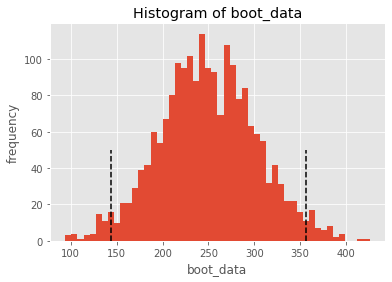

In [47]:
booted_data_mean = get_bootstrap(test_2, control_2, boot_it = 2000)

In [48]:
booted_data_mean["p_value"]

1.838492228224497e-06

In [49]:
booted_data_mean["ci"]

,0
0.025,144.004724
0.975,356.276786


In [50]:
# При сравнении средних в двух группах p-value < 0.05, и 0 в доверительный интервал не попадает. 
# Соответственно, нулевая гипотеза на заданном уровне значимости не принимается, и мы можем говорить, о статистическоь
# различии в средних в двух группах. 

Что все это значит для нас? Мы можем говорить, что на данном уроване значимости между контрольной и тестовой группами есть статистически значимые различия по среднему чеку. Средний чек в тестовой группе вырос. Видимо, новая модель оплаты, которую мы раскатали на тестовую группу, была успешна.

Единственное, на что я еще бы взглянула - это средний чек в  зависимости от платформы. Также бутсрапом. Почему хочу на это еще посмотреть - может нет статзначимых различий у пользователей на разных платформах в тесте и  в контроле, а разработка и поддержка на разных платформах стоит денег, и может нет смысла, допустим на android,  делать новую модель оплаты. Но посмотрим.

In [51]:
full_df_platform = full_df.groupby(['group', 'platform'], as_index=False)\
    .agg({'revenue' : 'sum', 'user_id' : 'count'})
full_df_platform

,group,platform,revenue,user_id
0,A,android,39898.0,39
1,A,ios,33700.0,39
2,B,android,208282.0,169
3,B,ios,189831.0,145


In [52]:
full_df_platform.assign(avg_check = full_df_platform.revenue/full_df_platform.user_id)

,group,platform,revenue,user_id,avg_check
0,A,android,39898.0,39,1023.025641
1,A,ios,33700.0,39,864.102564
2,B,android,208282.0,169,1232.437870
3,B,ios,189831.0,145,1309.179310


In [53]:
control_android = full_df.query('platform == "android" and group == "A"').revenue

In [54]:
test_android = full_df.query('platform == "android" and group == "B"').revenue

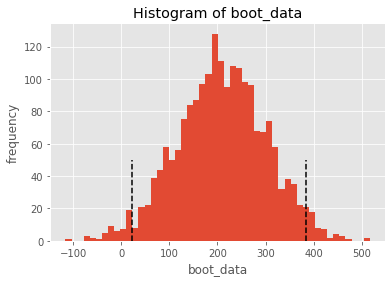

In [55]:
booted_data_mean = get_bootstrap(test_android, control_android, boot_it = 2000)

In [56]:
booted_data_mean["p_value"]

0.023083614667451235

In [57]:
booted_data_mean["ci"]

,0
0.025,21.682692
0.975,383.832840


In [58]:
control_ios = full_df.query('platform == "ios" and group == "A"').revenue

In [59]:
test_ios = full_df.query('platform == "ios" and group == "B"').revenue

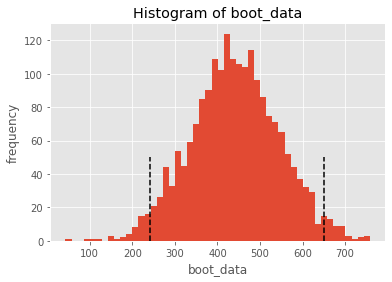

In [60]:
booted_data_mean = get_bootstrap(test_ios, control_ios, boot_it = 2000)

In [61]:
booted_data_mean["p_value"]

1.8636593077785246e-05

In [62]:
booted_data_mean["ci"]

,0
0.025,241.517931
0.975,651.195345


In [63]:
# Посмотрела, убедилась - средний чек значимо вырос в тестовой группе, даже если брать в разрезе платформы

Теперь посмотрим на конверсию в покупку в обеих группах.

In [136]:
group_A = active_users_per_groups.merge(purchases, how='left', on='user_id').query('group == "A"')
group_A

,user_id,country,platform,sex,group,revenue
8,4038,Russia,android,female,A,NaN
11,2427,Sweden,android,female,A,NaN
22,6772,Sweden,android,female,A,NaN
23,518,Russia,android,female,A,NaN
27,5220,Russia,ios,male,A,NaN
...,...,...,...,...,...,...
8298,3408,Russia,ios,male,A,NaN
8303,4519,Russia,ios,male,A,NaN
8306,7680,Russia,ios,male,A,NaN
8328,7111,Russia,android,male,A,NaN


In [137]:
CR_A = group_A.revenue.notna().sum()/group_A.shape[0]
CR_A

0.05071521456436931

In [138]:
group_B = active_users_per_groups.merge(purchases, how='left', on='user_id').query('group == "B"')
CR_B = group_B.revenue.notna().sum()/group_B.shape[0]
CR_B

0.046156107599588415

In [139]:
# На первый взгляд, конверсия в тестовой группе стала меньше, но хотелось бы понять, значимо ли данное различие.

In [140]:
# Буду использовать таблицу по всем активным пользователям с информацией об оплате
CR_df = active_users.merge(groups, how='inner', on='user_id').merge(purchases, how='left', on='user_id')
CR_df

,user_id,country,platform,sex,group,revenue
0,8029,Russia,ios,male,B,NaN
1,1735,Sweden,ios,male,B,NaN
2,7697,Russia,android,male,B,NaN
3,1421,Sweden,android,female,B,NaN
4,1704,Russia,ios,male,B,NaN
...,...,...,...,...,...,...
8336,2417,Sweden,ios,female,B,NaN
8337,3755,Russia,ios,male,A,590.0
8338,4594,Sweden,android,female,B,NaN
8339,7430,Sweden,ios,female,B,NaN


In [141]:
# Поскольку для расчета конверсии (отношение количеста оплативших полтзователей ко всем пользовтелям) нам важен 
# сам факт наличия оплаты, то заменим значения: 0 - для отсутствия оплаты, 1 - есть факт оплаты

CR_df['revenue'] = CR_df.revenue.apply(lambda x: 0 if np.isnan(x) else 1)

In [142]:
CR_df

,user_id,country,platform,sex,group,revenue
0,8029,Russia,ios,male,B,0
1,1735,Sweden,ios,male,B,0
2,7697,Russia,android,male,B,0
3,1421,Sweden,android,female,B,0
4,1704,Russia,ios,male,B,0
...,...,...,...,...,...,...
8336,2417,Sweden,ios,female,B,0
8337,3755,Russia,ios,male,A,1
8338,4594,Sweden,android,female,B,0
8339,7430,Sweden,ios,female,B,0


In [143]:
# Далее мы будем сравнивать две категориальные переменные: принадлежность к тестовой или контрольной группе и 
# наличие факта оплаты. Поэтому здесь мы можем применить хи-квадрат.
# Нулевая гипотеза говорит нам, взаимосвязи между переменными нет.
# Альтернативная - взаимосвязь есть.

In [144]:
pd.crosstab(CR_df.group, CR_df.revenue)

revenue,0,1
group,,
A,1460,78
B,6489,314


In [145]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(CR_df.group, CR_df.revenue))

In [146]:
stat, p

(0.48480826522557896, 0.48625240457231045)

In [147]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [148]:
#  Следовательно, здесь мы можем говорить, что на данном уровне значимости статзначимых различий в тестовой и 
# контрольной группах нет. Мы не можем отклонить нулевую гипотезу. Проще говоря, можно говорить о том, что конверсия
# не изменилась при введении  новой модели оплаты.

In [149]:
# Можно заглянуть глубже и иследовать на уровне платформы

In [150]:
CR_df_ios = CR_df.query('platform == "ios"')
CR_df_ios

,user_id,country,platform,sex,group,revenue
0,8029,Russia,ios,male,B,0
1,1735,Sweden,ios,male,B,0
4,1704,Russia,ios,male,B,0
5,4788,Russia,ios,female,B,0
7,7654,Russia,ios,female,B,0
...,...,...,...,...,...,...
8329,5666,Russia,ios,male,B,0
8335,3116,Russia,ios,male,B,0
8336,2417,Sweden,ios,female,B,0
8337,3755,Russia,ios,male,A,1


In [151]:
pd.crosstab(CR_df_ios.group, CR_df_ios.revenue)

revenue,0,1
group,,
A,665,39
B,2871,145


In [152]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(CR_df_ios.group, CR_df_ios.revenue))

In [153]:
stat, p

(0.5042373308565214, 0.4776441693023915)

In [154]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [155]:
CR_df_android = CR_df.query('platform == "android"')
CR_df_android

,user_id,country,platform,sex,group,revenue
2,7697,Russia,android,male,B,0
3,1421,Sweden,android,female,B,0
6,8324,Sweden,android,male,B,0
8,4038,Russia,android,female,A,0
9,797,Sweden,android,male,B,0
...,...,...,...,...,...,...
8332,1310,Russia,android,male,B,0
8333,2523,Sweden,android,female,B,0
8334,3838,Russia,android,male,B,0
8338,4594,Sweden,android,female,B,0


In [156]:
pd.crosstab(CR_df_android.group, CR_df_android.revenue)

revenue,0,1
group,,
A,795,39
B,3618,169


In [157]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(CR_df_android.group, CR_df_android.revenue))

In [158]:
stat, p

(0.03137316416817135, 0.8594104301864645)

In [159]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [160]:
# Исследуем на уровне страны

In [161]:
CR_df_Russia = CR_df.query('country == "Russia"')
CR_df_Russia

,user_id,country,platform,sex,group,revenue
0,8029,Russia,ios,male,B,0
2,7697,Russia,android,male,B,0
4,1704,Russia,ios,male,B,0
5,4788,Russia,ios,female,B,0
7,7654,Russia,ios,female,B,0
...,...,...,...,...,...,...
8332,1310,Russia,android,male,B,0
8334,3838,Russia,android,male,B,0
8335,3116,Russia,ios,male,B,0
8337,3755,Russia,ios,male,A,1


In [162]:
pd.crosstab(CR_df_Russia.group, CR_df_Russia.revenue)

revenue,0,1
group,,
A,872,43
B,4295,197


In [163]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(CR_df_android.group, CR_df_android.revenue))

In [164]:
stat, p

(0.03137316416817135, 0.8594104301864645)

In [165]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [166]:
CR_df_Sweden = CR_df.query('country == "Sweden"')
CR_df_Sweden

,user_id,country,platform,sex,group,revenue
1,1735,Sweden,ios,male,B,0
3,1421,Sweden,android,female,B,0
6,8324,Sweden,android,male,B,0
9,797,Sweden,android,male,B,0
11,2427,Sweden,android,female,A,0
...,...,...,...,...,...,...
8330,6038,Sweden,android,female,B,0
8333,2523,Sweden,android,female,B,0
8336,2417,Sweden,ios,female,B,0
8338,4594,Sweden,android,female,B,0


In [167]:
pd.crosstab(CR_df_Sweden.group, CR_df_Sweden.revenue)

revenue,0,1
group,,
A,588,35
B,2194,117


In [168]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(CR_df_android.group, CR_df_android.revenue))

In [169]:
stat, p

(0.03137316416817135, 0.8594104301864645)

In [170]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


In [98]:
# Тест показал, что различий в тестовой и контрольной группе нет ни на уровне страны, ни на уровне используемой
# платформы.

Какой можно сделать вывод? 
По результатам исследования данных мы видим значимое увеличение среднего чека в тестовой группе, причем конверсия значимо не изменилась. Данные были проанализированны в разрезе используемых платформ и страны пользователя. Видимо, в новой системе есть что-то такое, что побуждает платящих польхователей покупать более дорогие опции или больше товаров за раз, как результат растет средний чек. Даже не смотря на то, что конверсия не изменилась, можно говорить об увеличении прибыли. 
Поэтому рекомендую применить новую модель оплаты коллекций шаблонов ко всем пользователям.

4 ДАШБОРД

Одной из основных задач аналитика является не только построение моделей, но и создание дашбордов, которые позволяют отслеживать изменения метрик и принимать на их основе оптимальные решения. Ваш руководитель хочет узнать, как обстоят дела с использованием приложения и вовлечённостью пользователей, и очень просит спроектировать ему дашборд.

In [99]:
# выгружаем таблицу
active_users.merge(groups, how='inner', on='user_id')\
    .merge(purchases, how='left', on='user_id')\
    .to_csv('for_dashbord1.csv')

Ссылка на дашборд https://public.tableau.com/app/profile/mari.schneider/viz/ABTestResultsfinalproject/Dashboard1

После того, как уже оформила дашик, заинтересовали две группы пользователей:
1) Sweden_android_male - где в контрольной группе средний чек выше на 25 % ;
2) Russia_ios_male - где в тестовой группе средний чек как-то незначительно увеличился (7%) 

Посмотрим, насколько это значимо

In [100]:
df_1 = active_users.merge(groups, how='inner', on='user_id')\
    .merge(purchases, how='inner', on='user_id')\
    .groupby(['group', 'country', 'platform', 'sex'], as_index = False)\
    .agg({'revenue' : 'mean'})
df_1.head()

,group,country,platform,sex,revenue
0,A,Russia,android,female,843.636364
1,A,Russia,android,male,547.750000
2,A,Russia,ios,female,892.923077
3,A,Russia,ios,male,921.545455
4,A,Sweden,android,female,690.833333


In [101]:
# в подгруппе Sweden_android_male значимо ли,  что в контрольной группе средний чек больше.
# Нулевая гипотеза говорит нам, что различий в тестовой и контрольной группах нет.
# Альтернативная - что различия есть. 

In [102]:
B_Sweden_android_male = active_users.merge(groups, how='inner', on='user_id')\
    .merge(purchases, how='inner', on='user_id').query('group == "B" & country == "Sweden" & platform == "android" & sex == "male"')\
    .revenue


In [103]:
A_Sweden_android_male = active_users.merge(groups, how='inner', on='user_id')\
    .merge(purchases, how='inner', on='user_id').query('group == "A" & country == "Sweden" & platform == "android" & sex == "male"')\
    .revenue

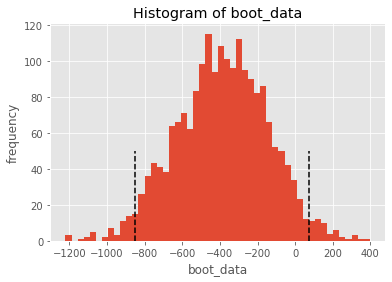

In [104]:
booted_data_mean = get_bootstrap(B_Sweden_android_male, A_Sweden_android_male, boot_it = 2000)

In [105]:
booted_data_mean["p_value"]

0.10995487118711038

In [106]:
booted_data_mean["ci"]

,0
0.025,-851.978030
0.975,75.729545


In [107]:
#критерий mann-whitney
# compare samples
stat, p = mannwhitneyu(B_Sweden_android_male, A_Sweden_android_male)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=187.500, p=0.316
Same distribution (fail to reject H0)


In [108]:
# и бутстрап, и критерий mann-whitney говорит, что мы не можем отвергнуть нулевую гипотезу, мы не можем сказать, 
# что в генеральной совокупности со старой моделью оплаты средний чек больше. Как бы получается, что в этой 
# подгруппе изменение модели оплаты не привело к каким-то статзнаимым изменениям

In [109]:
# в подгруппе Russia_ios_male в тестовой группе средний чек как-то незначительно увеличился (7%). Значимо ли это?
# Нулевая гипотеза говорит нам, что различий в тестовой и контрольной группах нет.
# Альтернативная - что различия есть.

In [110]:
B_Russia_ios_male = active_users.merge(groups, how='inner', on='user_id')\
    .merge(purchases, how='inner', on='user_id').query('group == "B" & country == "Sweden" & platform == "android" & sex == "male"')\
    .revenue

In [111]:
A_Russia_ios_male = active_users.merge(groups, how='inner', on='user_id')\
    .merge(purchases, how='inner', on='user_id').query('group == "A" & country == "Sweden" & platform == "android" & sex == "male"')\
    .revenue

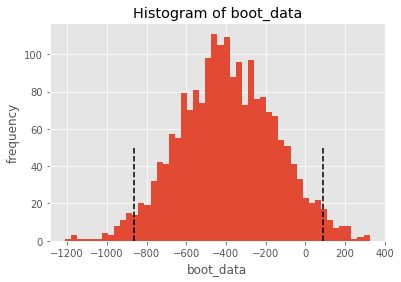

In [112]:
booted_data_mean = get_bootstrap(B_Russia_ios_male, A_Russia_ios_male, boot_it = 2000)

In [113]:
booted_data_mean["p_value"]

0.10814642988895976

In [114]:
booted_data_mean["ci"]

,0
0.025,-865.370455
0.975,89.853030


In [115]:
#критерий mann-whitney
# compare samples
stat, p = mannwhitneyu(B_Russia_ios_male, A_Russia_ios_male)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=187.500, p=0.316
Same distribution (fail to reject H0)


In [116]:
# и бутстрап, и критерий mann-whitney говорит, что мы не можем отвергнуть нулевую гипотезу,получается, что в этой 
# подгруппе изменение модели оплаты не привело к каким-то статзнаимым изменениям

В общем и целом, вывод не поменялся - рекомендую применить новую модель оплаты коллекций шаблонов ко всем пользователям.
Однако, можно обратить внимание на две подгруппы, для которых, изменение не отразилось в какие-то значимые результаты. 